<a href="https://colab.research.google.com/github/NateOberdier/pHase/blob/main/pHase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, warnings
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, classification_report, mean_squared_error, r2_score, brier_score_loss

warnings.filterwarnings("ignore")

FILE_ID = "1N72GfA76iHDD2AKpoevpY3hLpWH7Zszi"
OUTPUT_CSV = "MilkLog.csv"

if not os.path.exists(OUTPUT_CSV):
    import gdown
    gdown.download(f"https://drive.google.com/uc?id={FILE_ID}", OUTPUT_CSV, quiet=False)

df_raw = pd.read_csv(OUTPUT_CSV)

STAGE_ORDER = [
    "fresh",
    "sour",
    "yogurt",
    "kefir",
    "curding",
    "cheese"
]

CONFIG = {
    "temperature_F": 68.0,
    "random_seed": 42
}

np.random.seed(CONFIG["random_seed"])

print("Raw data shape:", df_raw.shape)
print("Stages:", STAGE_ORDER)


Raw data shape: (50, 14)
Stages: ['fresh', 'sour', 'yogurt', 'kefir', 'curding', 'cheese']


Feature data shape: (600, 15)
Stage counts:
stage_hard
cheese       1
curding     21
fresh       71
kefir      421
sour        53
yogurt      33
Name: count, dtype: int64


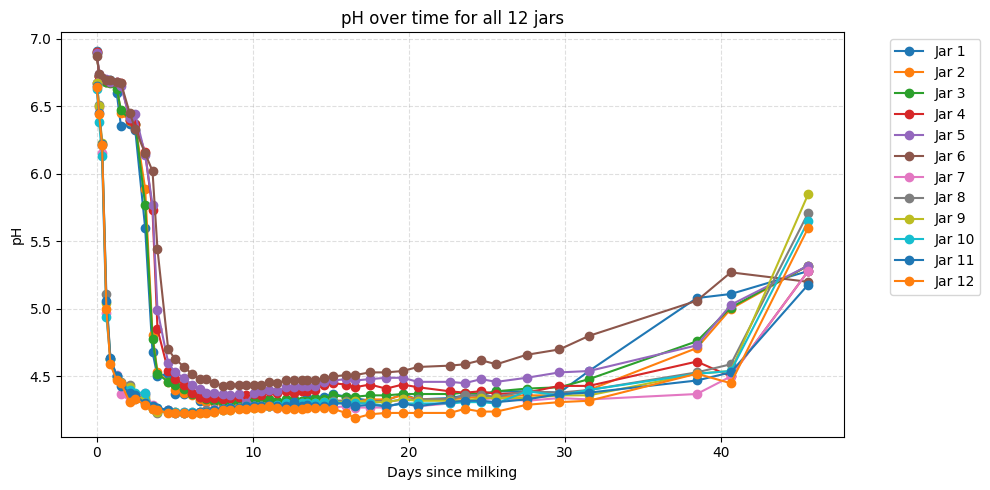

In [22]:
value_cols = [c for c in df_raw.columns if c not in ["Date", "Time"]]
df_long = df_raw.melt(
    id_vars=["Date", "Time"],
    value_vars=value_cols,
    var_name="jar_id",
    value_name="pH"
)

df_long["datetime"] = pd.to_datetime(
    df_long["Date"].astype(str) + " " + df_long["Time"].astype(str),
    format="%d-%b %H:%M"
)

t0 = df_long["datetime"].min()
df_long["hours_since_milking"] = (df_long["datetime"] - t0).dt.total_seconds() / 3600.0
df_long["days_since_milking"] = df_long["hours_since_milking"] / 24.0
df_long["jar_num"] = df_long["jar_id"].astype(int)
df_long["has_culture"] = (df_long["jar_num"] > 6).astype(int)

def engineer_features(df_long):
    df = df_long.copy()
    df["pH_smooth"] = (
        df.groupby("jar_id")["pH"]
          .apply(lambda s: s.ewm(alpha=0.3, adjust=False).mean())
          .reset_index(level=0, drop=True)
    )
    def compute_slope(g):
        h = g["hours_since_milking"].values
        p = g["pH_smooth"].values
        dpdt = np.zeros_like(p)
        if len(p) > 1:
            dpdt[1:] = np.diff(p) / np.maximum(1e-3, np.diff(h))
        return np.clip(dpdt, -0.2, 0.2)
    df["dpH_dt"] = df.groupby("jar_id", group_keys=False).apply(
        lambda g: pd.Series(compute_slope(g), index=g.index)
    )
    df["temperature_F"] = CONFIG["temperature_F"]
    df["pH_x_hours"] = df["pH_smooth"] * df["hours_since_milking"]
    df["hours_sq"] = df["hours_since_milking"] ** 2
    return df

df_feat = engineer_features(df_long)

def heuristic_stage(ph, days):
    if days >= 30 and ph >= 5.0:
        return "cheese"
    if days >= 20 and ph >= 4.6:
        return "curding"
    if ph > 6.45:
        return "fresh"
    if ph >= 5.0:
        return "sour"
    if ph >= 4.6:
        return "yogurt"
    return "kefir"

def assign_stages_monotonic(df):
    df = df.sort_values(["jar_id", "hours_since_milking"]).copy()
    labels = []
    for jar, g in df.groupby("jar_id"):
        prev_idx = 0
        for _, row in g.iterrows():
            raw = heuristic_stage(row["pH_smooth"], row["days_since_milking"])
            idx_raw = STAGE_ORDER.index(raw)
            idx = max(prev_idx, idx_raw)
            labels.append(STAGE_ORDER[idx])
            prev_idx = idx
    df["stage_hard"] = labels
    return df

df_feat = assign_stages_monotonic(df_feat)

print("Feature data shape:", df_feat.shape)
print("Stage counts:")
print(df_feat["stage_hard"].value_counts().sort_index())

plt.figure(figsize=(10, 5))
for jar in sorted(df_feat["jar_id"].unique(), key=lambda x: int(x)):
    sub = df_feat[df_feat["jar_id"] == jar]
    plt.plot(sub["days_since_milking"], sub["pH"], marker="o", linestyle="-", label=f"Jar {jar}")
plt.xlabel("Days since milking")
plt.ylabel("pH")
plt.title("pH over time for all 12 jars")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


Train jars: ['1', '2', '3', '6', '8', '9', '10', '12']
Val jars:   ['5', '7']
Test jars:  ['4', '11']
Random Forest stage classification (full features)
Accuracy: 1.0
Macro F1: 1.0
              precision    recall  f1-score   support

     curding      1.000     1.000     1.000         2
       fresh      1.000     1.000     1.000        12
       kefir      1.000     1.000     1.000        72
        sour      1.000     1.000     1.000         9
      yogurt      1.000     1.000     1.000         5

    accuracy                          1.000       100
   macro avg      1.000     1.000     1.000       100
weighted avg      1.000     1.000     1.000       100

Avg Brier score: 0.0005498775510204083
Random Forest pH regression (full features)
RMSE: 0.0374857381213172
R^2: 0.9975648915681575


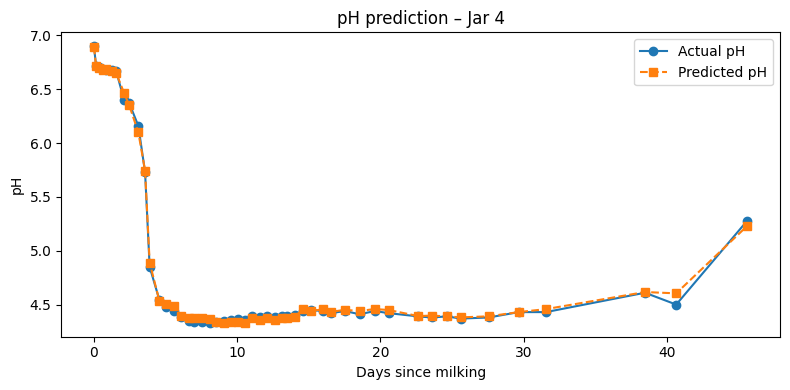

Max hours in dataset: 1094.8333333333333
Label-derived first stage times (days) – cultured:
fresh : 0.0
sour : 0.3333333333333333
yogurt : 2.1041666666666665
kefir : 3.097222222222222
curding : 45.61805555555555
cheese : no data
Label-derived first stage times (days) – no culture:
fresh : 0.0
sour : 3.097222222222222
yogurt : 5.013888888888888
kefir : 6.604166666666667
curding : 27.555555555555557
cheese : 45.61805555555555


In [23]:
no_culture_jars = [1, 2, 3, 4, 5, 6]
with_culture_jars = [7, 8, 9, 10, 11, 12]

def stratify_group(jars, seed):
    np.random.seed(seed)
    jars = np.array(jars)
    np.random.shuffle(jars)
    train = jars[:4]
    val   = jars[4:5]
    test  = jars[5:6]
    return train.tolist(), val.tolist(), test.tolist()

no_train, no_val, no_test = stratify_group(no_culture_jars, CONFIG["random_seed"])
yes_train, yes_val, yes_test = stratify_group(with_culture_jars, CONFIG["random_seed"] + 1)

train_jars = no_train + yes_train
val_jars   = no_val   + yes_val
test_jars  = no_test  + yes_test

train_df = df_feat[df_feat["jar_num"].isin(train_jars)].copy()
val_df   = df_feat[df_feat["jar_num"].isin(val_jars)].copy()
test_df  = df_feat[df_feat["jar_num"].isin(test_jars)].copy()

print("Train jars:", sorted(train_df["jar_id"].unique(), key=int))
print("Val jars:  ", sorted(val_df["jar_id"].unique(), key=int))
print("Test jars: ", sorted(test_df["jar_id"].unique(), key=int))

FEATURES_FULL = [
    "pH_smooth",
    "hours_since_milking",
    "dpH_dt",
    "pH_x_hours",
    "hours_sq",
    "temperature_F",
    "has_culture"
]

X_train_full, y_train_full = train_df[FEATURES_FULL], train_df["stage_hard"]
X_val_full,   y_val_full   = val_df[FEATURES_FULL],   val_df["stage_hard"]
X_test_full,  y_test_full  = test_df[FEATURES_FULL],  test_df["stage_hard"]

clf_full = RandomForestClassifier(
    n_estimators=350,
    max_depth=None,
    random_state=CONFIG["random_seed"],
    n_jobs=-1
)
clf_full.fit(X_train_full, y_train_full)

y_pred_full = clf_full.predict(X_test_full)
proba_full = clf_full.predict_proba(X_test_full)

print("Random Forest stage classification (full features)")
print("Accuracy:", accuracy_score(y_test_full, y_pred_full))
print("Macro F1:", f1_score(y_test_full, y_pred_full, average="macro"))
print(classification_report(y_test_full, y_pred_full, digits=3))

stage_to_idx_full = {c: i for i, c in enumerate(clf_full.classes_)}
briers = []
for cls in clf_full.classes_:
    y_true = (y_test_full.values == cls).astype(int)
    y_hat  = proba_full[:, stage_to_idx_full[cls]]
    briers.append(brier_score_loss(y_true, y_hat))
print("Avg Brier score:", np.mean(briers))

reg_full = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=CONFIG["random_seed"],
    n_jobs=-1
)
reg_full.fit(train_df[FEATURES_FULL], train_df["pH"])

pH_hat_full = reg_full.predict(test_df[FEATURES_FULL])
mse_full  = mean_squared_error(test_df["pH"], pH_hat_full)
rmse_full = mse_full ** 0.5
r2_full   = r2_score(test_df["pH"], pH_hat_full)
print("Random Forest pH regression (full features)")
print("RMSE:", rmse_full)
print("R^2:", r2_full)

sample_jar = sorted(test_df["jar_id"].unique(), key=int)[0]
mask = test_df["jar_id"] == sample_jar
sub_true = test_df[mask].sort_values("hours_since_milking")
sub_pred = pH_hat_full[mask.values]

plt.figure(figsize=(8, 4))
plt.plot(sub_true["days_since_milking"], sub_true["pH"], "o-", label="Actual pH")
plt.plot(sub_true["days_since_milking"], sub_pred, "s--", label="Predicted pH")
plt.xlabel("Days since milking")
plt.ylabel("pH")
plt.title(f"pH prediction – Jar {sample_jar}")
plt.legend()
plt.tight_layout()
plt.show()

X_time_all = df_feat[["hours_since_milking", "has_culture"]]
y_pH_all = df_feat["pH"]

reg_time = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=CONFIG["random_seed"],
    n_jobs=-1
)
reg_time.fit(X_time_all, y_pH_all)

MAX_HOURS_DATA = float(df_feat["hours_since_milking"].max())
print("Max hours in dataset:", MAX_HOURS_DATA)

df_first = (
    df_feat.sort_values("hours_since_milking")
          .groupby(["has_culture", "stage_hard"])["hours_since_milking"]
          .min()
          .reset_index()
)

stage_first_times_cultured = {
    row["stage_hard"]: float(row["hours_since_milking"])
    for _, row in df_first[df_first["has_culture"] == 1].iterrows()
}

stage_first_times_noculture = {
    row["stage_hard"]: float(row["hours_since_milking"])
    for _, row in df_first[df_first["has_culture"] == 0].iterrows()
}

print("Label-derived first stage times (days) – cultured:")
for st in STAGE_ORDER:
    if st in stage_first_times_cultured:
        print(st, ":", stage_first_times_cultured[st] / 24.0)
    else:
        print(st, ": no data")

print("Label-derived first stage times (days) – no culture:")
for st in STAGE_ORDER:
    if st in stage_first_times_noculture:
        print(st, ":", stage_first_times_noculture[st] / 24.0)
    else:
        print(st, ": no data")


In [25]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime
from zoneinfo import ZoneInfo
import math
import numpy as np

def fermentation_speed_factor(temp_F, has_culture, Q10=2.0, culture_boost=1.5):
    T_ref_C = (68.0 - 32) * 5/9
    T_user_C = (temp_F - 32) * 5/9
    temp_factor = Q10 ** ((T_user_C - T_ref_C) / 10.0)
    cult_factor = culture_boost if has_culture else 1.0
    return temp_factor * cult_factor

def format_delta_hours(delta_h):
    d = abs(delta_h)
    days = int(d // 24)
    hours = int(round(d % 24))
    if days == 0 and hours == 0:
        return "≈ now"
    parts = []
    if days > 0:
        parts.append(f"{days} day{'s' if days != 1 else ''}")
    if hours > 0:
        parts.append(f"{hours} hour{'s' if hours != 1 else ''}")
    return "in ~" + " and ".join(parts)

def stage_from_hours(hours_equiv_68, has_culture_bool):
    ph = float(reg_time.predict([[hours_equiv_68, int(has_culture_bool)]])[0])
    days = hours_equiv_68 / 24.0
    st = heuristic_stage(ph, days)
    if has_culture_bool and st.lower() == "kefir":
        st = "yogurt"
    if (not has_culture_bool) and st.lower() == "yogurt":
        st = "kefir"
    return st, ph

def model_future_times(hours_now, has_culture_bool, step_hours=0.5, extra_days=10.0):
    horizon = max(MAX_HOURS_DATA, hours_now) + extra_days * 24.0
    times = np.arange(hours_now, horizon + step_hours / 2.0, step_hours)
    has_vec = np.full_like(times, int(has_culture_bool), dtype=float)
    X = np.column_stack([times, has_vec])
    ph_seq = reg_time.predict(X)

    stages = []
    for t, ph in zip(times, ph_seq):
        days = t / 24.0
        st = heuristic_stage(ph, days)
        if has_culture_bool and st.lower() == "kefir":
            st = "yogurt"
        if (not has_culture_bool) and st.lower() == "yogurt":
            st = "kefir"
        stages.append(st)

    current_stage = stages[0]
    first_model = {}
    for st in STAGE_ORDER:
        if has_culture_bool and st.lower() == "kefir":
            continue
        if (not has_culture_bool) and st.lower() == "yogurt":
            continue
        if st == current_stage:
            continue
        idx = np.where(np.array(stages) == st)[0]
        if len(idx) > 0:
            first_model[st] = float(times[idx[0]])

    return current_stage, first_model

title = widgets.HTML(
    "<b>Interactive raw-milk fermentation assistant "
    "(fresh → sour → yogurt/kefir → curding → cheese)</b>"
)

now_et = datetime.datetime.now(ZoneInfo("America/New_York"))

month_dropdown = widgets.Dropdown(
    options=list(zip(
        ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
        range(1,13)
    )),
    value=now_et.month,
    layout=widgets.Layout(width="90px")
)
day_dropdown = widgets.Dropdown(
    options=list(range(1,32)),
    value=now_et.day,
    layout=widgets.Layout(width="70px")
)
year_dropdown = widgets.Dropdown(
    options=[now_et.year],
    value=now_et.year,
    layout=widgets.Layout(width="80px")
)

hour_dropdown = widgets.Dropdown(
    options=list(range(1,13)),
    value=((now_et.hour - 1) % 12) + 1,
    layout=widgets.Layout(width="60px")
)
minute_dropdown = widgets.Dropdown(
    options=[0, 30],
    value=0 if now_et.minute < 30 else 30,
    layout=widgets.Layout(width="60px")
)
ampm_dropdown = widgets.Dropdown(
    options=["AM", "PM"],
    value="PM" if now_et.hour >= 12 else "AM",
    layout=widgets.Layout(width="70px")
)

temp_input = widgets.BoundedFloatText(
    value=68.0,
    min=50.0,
    max=90.0,
    step=0.5,
    layout=widgets.Layout(width="80px")
)

culture_dropdown = widgets.Dropdown(
    options=[("no", False), ("yes", True)],
    value=False,
    layout=widgets.Layout(width="70px")
)

predict_button = widgets.Button(
    description="Predict",
    button_style="success",
    layout=widgets.Layout(width="80px")
)

status_label = widgets.Label(
    "Choose start date/time, temp, culture, then click 'Predict'."
)

output = widgets.Output()

controls_row = widgets.HBox([
    widgets.Label("Start:", layout=widgets.Layout(width="45px")),
    month_dropdown,
    day_dropdown,
    year_dropdown,
    widgets.Label("Time:", layout=widgets.Layout(width="40px")),
    hour_dropdown,
    widgets.Label(":", layout=widgets.Layout(width="10px")),
    minute_dropdown,
    ampm_dropdown,
    widgets.Label("Temp°F:", layout=widgets.Layout(width="60px")),
    temp_input,
    widgets.Label("Culture:", layout=widgets.Layout(width="60px")),
    culture_dropdown,
    predict_button
])

def on_predict_clicked(b):
    with output:
        clear_output()

        year = year_dropdown.value
        month = month_dropdown.value
        day = day_dropdown.value
        h12 = hour_dropdown.value
        minute = int(minute_dropdown.value)
        ampm = ampm_dropdown.value

        if ampm == "PM" and h12 != 12:
            h24 = h12 + 12
        elif ampm == "AM" and h12 == 12:
            h24 = 0
        else:
            h24 = h12

        try:
            start_dt = datetime.datetime(
                year, month, day, h24, minute, tzinfo=ZoneInfo("America/New_York")
            )
        except ValueError as e:
            status_label.value = f"Invalid date: {e}"
            return

        now = datetime.datetime.now(ZoneInfo("America/New_York"))
        elapsed_h = (now - start_dt).total_seconds() / 3600.0
        if elapsed_h < 0:
            status_label.value = "Start time is in the future — choose an earlier date/time."
            return

        temp_F = float(temp_input.value)
        has_culture = culture_dropdown.value

        speed_temp_only = fermentation_speed_factor(temp_F, False)
        hours_equiv_68 = elapsed_h * speed_temp_only
        days_equiv_68 = hours_equiv_68 / 24.0

        stage_now, ph_est = stage_from_hours(hours_equiv_68, has_culture)

        status_label.value = (
            f"Batch started {start_dt.strftime('%Y-%m-%d %I:%M %p')} ET, "
            f"{elapsed_h:.1f}h elapsed at {temp_F:.1f}°F "
            f"({'culture' if has_culture else 'no culture'})."
        )

        print("=== Fermentation Status (model + labels) ===")
        print(f"Start (ET):  {start_dt.strftime('%Y-%m-%d %I:%M %p')}")
        print(f"Now (ET):    {now.strftime('%Y-%m-%d %I:%M %p')}")
        print(f"Elapsed real time: {elapsed_h:.1f} h")
        print(f"Temperature: {temp_F:.1f}°F")
        print(f"Culture added: {'Yes' if has_culture else 'No'}")
        print(f"Effective 68°F hours (temp only): {hours_equiv_68:.1f} h "
              f"({days_equiv_68:.1f} days at 68°F)\n")

        print(f"Estimated pH (reg_time): ~{ph_est:.2f}")
        print(f"Estimated stage: {stage_now}\n")

        print("=== Upcoming Stage Changes (same model, with label fallback) ===")

        model_current, model_first = model_future_times(hours_equiv_68, has_culture)

        if has_culture:
            label_first = stage_first_times_cultured
        else:
            label_first = stage_first_times_noculture

        if stage_now in STAGE_ORDER:
            current_idx = STAGE_ORDER.index(stage_now)
        else:
            current_idx = -1

        future_map = {}
        for st in STAGE_ORDER:
            if has_culture and st.lower() == "kefir":
                continue
            if (not has_culture) and st.lower() == "yogurt":
                continue
            if st not in STAGE_ORDER:
                continue
            idx = STAGE_ORDER.index(st)
            if idx <= current_idx:
                continue

            candidates = []

            t_model = model_first.get(st)
            if t_model is not None and t_model > hours_equiv_68:
                candidates.append(t_model)

            t_label = label_first.get(st)
            if t_label is not None and t_label > hours_equiv_68:
                candidates.append(t_label)

            if candidates:
                t_best = min(candidates)

                if (not has_culture) and (st.lower() == "curding"):
                    min_cur_hours = 35.0 * 24.0
                    if t_best < min_cur_hours:
                        t_best = min_cur_hours

                future_map[st] = t_best

        if not future_map:
            print("All remaining stages have already passed according to this model.")
        else:
            for st in STAGE_ORDER:
                if st not in future_map:
                    continue
                delta = future_map[st] - hours_equiv_68
                when = format_delta_hours(delta)
                print(f"  {st:15s}: {when}")

predict_button.on_click(on_predict_clicked)

ui = widgets.VBox([
    title,
    controls_row,
    status_label,
    output
])

display(ui)
